# <center>Surging Churn an Urgent Concern </center>

<img src="img/leaky_customers.jpg" width=600 height=600 />

In [1]:
# Data manipulation imports
import pandas as pd
import numpy as np
import scipy.stats as stats

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Custom module imports
import acquire
import prepare
import explore
import model

# Overall Project Plan
- Acquire data from the Codeup Database. Create an acquire.py file containing a function to automate the process.
- Initial inquiry into the data to see the shape and layout of things. This will help inform initial cleaning and prep of data.
- Clean and prepare data for the explore phase. Create an acquire.py to store functions I create to automate the cleaning and preperation process. This will involve an encoding step for all categorical data before moving on to exploring the data.
- Begin exploring the data and ask questions leading to clarity of what is happening in the data. Clearly define at least three hypotheses, set an alpha, run any statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways. Automate as much as possible and put all functions into an explore.py file
- After thoroughly exploring the data, do any final preparation necessary to begin modeling. Automate this function and put it into a model.py file
- Train at least three different classification models.
- Evaluate models on train and validate datasets. Do further hyperparamter iteration to find the best performing models. Save all iteration functions to be automated in the model.py file.
- Choose the model with that performs the best and do final hyperparameter tuning feature selfection.
- Evaluate that single model on the test dataset.
- Create a csv file containing customer_id, probability of churn, and prediction of churn by using my final model on the test dataset.
- Construct a Final Report Notebook wherein I show how I arrived at the MVP model by using my created modules. Throughout the notebook,document conclusions, takeaways, and next steps.
- Create README.md with data dictionary, project and business goals, initial hypothesis and an executive summary

## Executive Summary
- Of all the classification models I created DecisionTree and RandomForest performed the best.
- I chose RandomForest as my best performing model and achieved a 80.9% for predicting my target value, churn. This model outperformed the baseline accuracy score of 73.4% so it has predictive value.
- There were some clear drivers of churn in the dataset. They are noted herein.
- Given further time, I would like to experiment with engineering some more valuable features using the data available to see if I can improve the model.
- Additionally it would be nice to have some specific information surrounding how a customer churned, see conclusions for specifics

## Acquire Data

In [2]:
# Read telco data into a dataframe
df = acquire.get_telco_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
acquire.describe_with_range(df.drop(columns=['internet_service_type_id','payment_type_id', 'contract_type_id', 'senior_citizen']))

,count,mean,std,min,25%,50%,75%,max,range
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00,72.0
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75,100.5


### Acquire Takeaways

- Within my Acquire.py script, I wrote an SQL query which pulls the relevant Telco data from the Codeup Database. It then stores it in a locally cached .csv file for quick future access.
- The raw data pulled in contains 7043 rows and 24 columns.
- There are no obvious nulls present and it remains to be seen what data will be usable.
- Upon summary investigation, it's obvious that several columns data types are classified incorrectly.
    - Columns internet_service_type_id, payment_type_id, and contract_type_id are all categorical data and should be stored as objects, not numerical data (int64).
    - The senior_citizen column is also categorical data that I will leave as numerical as it will be encoded later anyway.
    - total_charges contains numerical data that is stored as an object.
    - These will need to be dealt with during the prepare stage.

## Prepare Data

Upon further investigation, I found that internet_service_type_id, payment_type_id, contract_type_id columns are all redundant; the same information is stored in other columns.  I will be dropping these three columns.  

See the cell below for an example

In [5]:
df.internet_service_type.value_counts(), df.internet_service_type_id.value_counts()

(Fiber optic    3096
 DSL            2421
 None           1526
 Name: internet_service_type, dtype: int64,
 2    3096
 1    2421
 3    1526
 Name: internet_service_type_id, dtype: int64)

Additionally, the information in the phone_service column is 100% reproduced with MORE info in the multiple_lines column. As such I will be dropping the phone_service column.

Dealing with total_charges is a bit more tricky as there were blanks used in place of null or zero values. I will convert those to zeros and then change the entire column to a numeric dataframe.

In [6]:
# Getting value_counts of all the categorial columns
acquire.obj_val_cnt(df.drop(columns= 'customer_id'))

Male      3555
Female    3488
Name: gender, dtype: int64
No     3641
Yes    3402
Name: partner, dtype: int64
No     4933
Yes    2110
Name: dependents, dtype: int64
Yes    6361
No      682
Name: phone_service, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: device_protection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
No                     2810
Yes                    2707
No internet service    1526
Name: streaming_tv, dtype: int64
No                     2785
Yes                    2732
No internet servic

For several of the categorical variables displayed above there are three categories that look like:
- Yes
- No
- No phone service / No internet service

Since this information about "No phone service / No internet service" is also contained in the "phone_service" and "internet_service_type" columns, this data is redundant and I will be changing all instances of "No phone service / No internet service" to No. These categorical variables will have an output of either "Yes" or "No".

Further, for ease of exploring and working with the data, several categorical variable values need to be changed to snake case, e.g. 'Fiber optic' to 'fiber_optic'.

I found there are 11 total customers who have no total_charges and 11 total customers who have a tenure of 0. All 11 of these customers have 0 tenure. Since they have no possibility of churning, I'm dropping these customers from the dataset.

In [7]:
# Cleaning the data

df = prepare.clean_telco(df)

In [8]:
# Encoding categorical columns

df = prepare.encode_telco(df)

In [9]:
# Splitting the data, stratifying by target of churn.

train, test, validate = prepare.split_telco(df)

print(f"The shape of train is {train.shape[0]} rows and {train.shape[1]} columns")
print(f"The shape of train is {validate.shape[0]} rows and {validate.shape[1]} columns")
print(f"The shape of train is {test.shape[0]} rows and {test.shape[1]} columns")

The shape of train is 3937 rows and 39 columns
The shape of train is 1407 rows and 39 columns
The shape of train is 1688 rows and 39 columns


### Prepare Takeaways

- I determined the following columns should be dropped due to being redundant data: 
    - internet_service_type_id
    - payment_type_id
    - contract_type_id
    - phone_service
- For the total_charges column, I replaced all empty values as 0. The column was then converted to numerical data.
- While evaluating the new total_charges I noticed that all rows where total_charges were 0, tenure and churn was also 0. Since there is no possibility of these customers churning, I'm dropping these rows.
- Several categorical variables had names or phrases that I converted to snake case to help with handeling the data in the exploration phase next.
- After cleaning the data I then encoded all categorical data, and split it into train, validate, and test subsets, stratifying by the target of churn.
- Within my prepare.py script, I wrote functions to perform the above transformations.

In [10]:
train.payment_type.value_counts()

electronic_check           1322
mailed_check                909
credit_card_automatic       859
bank_transfer_automatic     847
Name: payment_type, dtype: int64

## Explore (Exploratory Data Analysis)

All exploration of the data will be done solely on the train subset data.

In [11]:
# Dropping unnecessary columns for exploration (all encoded data and customer_id)
train_explore = train.drop(columns = ['customer_id', 'gender_Male', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
        'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes', 
        'streaming_movies_Yes', 'paperless_billing_Yes', 'churn_Yes', 'contract_type_one_year', 'contract_type_two_year',
        'payment_type_credit_card_automatic', 'payment_type_electronic_check', 'payment_type_mailed_check',
        'internet_service_type_None', 'internet_service_type_fiber_optic'])

### Continous Variables
Exploring continous variables

<AxesSubplot:>

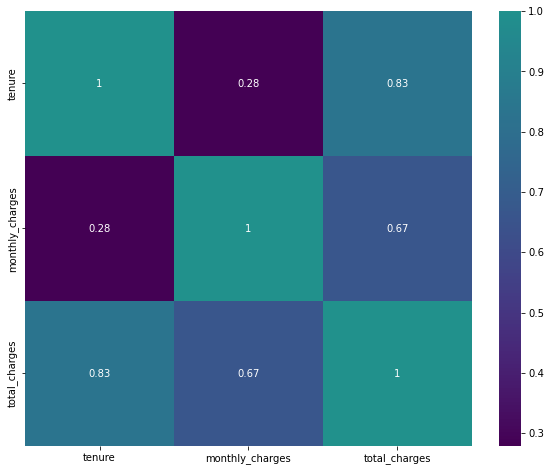

In [12]:
# Viewing all continuous data in a heatmap to see if there is any strong correlation present between features.
cont_var = train_explore.drop('senior_citizen', axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(cont_var.corr(), cmap='viridis', center=1, annot=True)

#### Takeaways from Heatmap:
- There are not many continuous variables to compare in the Telco dataset as most are categorical variables.
- Of the three that continuous variable columns, tenure and total_charges are correlated most strongly 
    - depending on how the models perform later, I may want to exclude either tenure or total charges to see if this makes a clearer picture for the model to predict on. It would make sense total charges would increase with tenure.


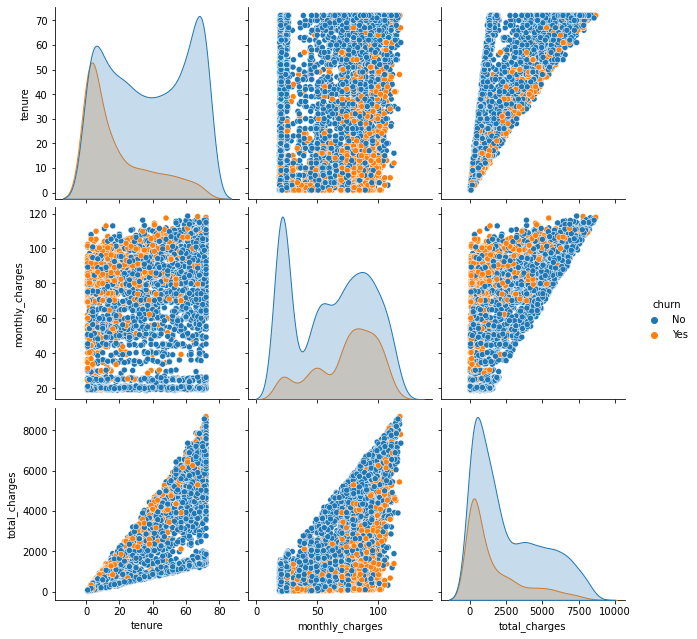

In [13]:
sns.pairplot(cont_var, hue='churn', height = 3)
plt.show()

#### Takeaways from pairplot:
- It looks as though there are significant differences between churn and no churn for all of the given features: total_charges, monthly_charges, and tenure.
- It also looks like higher monthly charges and lower tenure may be stronger drivers for churn.
- I will need to hypothesis test these.

**Hypothesis testing for continous variables**

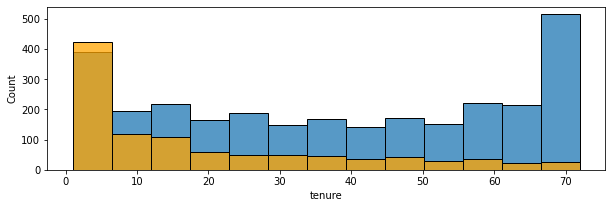

The levene test for tenure when comparing churn vs no churn shows a p value of 4.918222765354178e-46 
which means the variance is not equal.


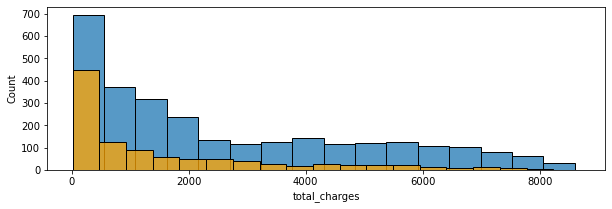

The levene test for total_charges when comparing churn vs no churn shows a p value of 3.220782732845082e-20 
which means the variance is not equal.


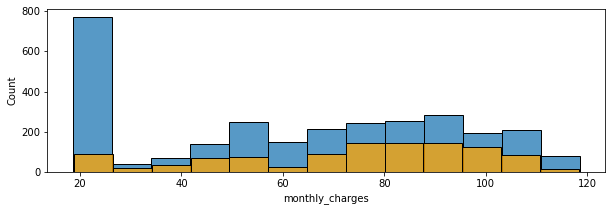

The levene test for monthly_charges when comparing churn vs no churn shows a p value of 2.6620656867750108e-36 
which means the variance is not equal.


In [14]:
# Looking for normality and variance between churn and no churn in the continous variables.
explore.normality_testing(train_explore)

For my t-tests:
- Even though the graphs aren't normal, they are large enough to assume normality due to the central limit theorem.
- They are independent of one another by definition.
- None of the variables have equal variance when split between churn and no churn. I will set equal_var=False.

I will run a two sample, two tailed t-test for each continous variable to see if there is any signficant difference between churn and no churn.

In [15]:
# Setting my alpha
alpha = .05

**Question:** Is there a difference in tenure between customers who churned and customes who didn't?

**Hypothesis 1:**

$H_{0}$ There is no difference in tenure between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in tenure between customers who churned and customers who didn't churn.

In [16]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].tenure, train_explore[train_explore.churn == 'No'].tenure, equal_var=False)

if p < alpha:
    print(f"P is less than alpha with a value of {p}")
else:
    print(f"P is more than alpha with a value of {p}")

P is less than alpha with a value of 1.0184830572431322e-122


Reject the Null; There is a statistically significant difference in tenure between customers who churned and customers who didn't churn.


**Question:** Is there a difference in monthly_charges between customers who churned and customes who didn't?

**Hypothesis 2:**

$H_{0}$ There is no difference in monthly_charges between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.

In [17]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].monthly_charges, train_explore[train_explore.churn == 'No'].monthly_charges, equal_var=False)

if p < alpha:
    print(f"P is less than alpha with a value of {p}")
else:
    print(f"P is more than alpha with a value of {p}")

P is less than alpha with a value of 1.4724622662838922e-32


Reject the Null; There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.


**Question:** Is there a difference in total_charges between customers who churned and customes who didn't?

**Hypothesis 3:**

$H_{0}$ There is no difference in total_charges between customers who churned and customers who didn't churn.

$H_{a}$ There is a statistically significant difference in total_charges between customers who churned and customers who didn't churn.

In [18]:
t, p = stats.ttest_ind(train_explore[train_explore.churn == 'Yes'].total_charges, train_explore[train_explore.churn == 'No'].total_charges, equal_var=False)

if p < alpha:
    print(f"P is less than alpha with a value of {p}")
else:
    print(f"P is more than alpha with a value of {p}")

P is less than alpha with a value of 4.576798001002561e-40


Reject the Null; There is a statistically significant difference in monthly_charges between customers who churned and customers who didn't churn.


**Results from t-tests of continous variables**

- All continous variables when split between customers who churned and didn't churn show statistically significant differences.
- Tenure had the strongest results.
- I will use all continuous variables as features for modeling initially though I may drop total_charges due to correlation between it and tenure (see heatmap above).

### Categorical Variables
Exploring Categorical variables

In [19]:
# Making a categorical list for exploration. Concatenating senior_citizen to the objects as it is technically a 
# categorical variable encoded as a numerical one.
explore_cat = train_explore.select_dtypes(object)
explore_cat = pd.concat([explore_cat, train_explore.senior_citizen], axis = 1)

In [20]:
# Running a chi squared test for every categorical column to determine which features have a statistically signficant 
# relationship with the target of churn.
chi2_results = explore.explore_categoricals(explore_cat, 'churn', only_report=True)

Statistically signficant relationships with the target variable (churn) were found with the following features:
['partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'payment_type', 'internet_service_type', 'senior_citizen']
----------------------------------

Statistically signficant relationships with the target variable (churn) were NOT found with the following features:
['gender', 'multiple_lines']


In [21]:
# Showing variable names and p value results from the chi2 test for all variables where p < alpha.
chi2_results.sort_values('p_value')

,feature,p_value
9,churn,0.000000e+00
10,contract_type,3.957406e-140
12,internet_service_type,2.781527e-77
11,payment_type,7.032806e-72
8,paperless_billing,6.745165e-33
1,dependents,2.424982e-28
2,online_security,1.257737e-27
5,tech_support,1.316224e-25
13,senior_citizen,3.088301e-25
0,partner,6.453486e-22


[]

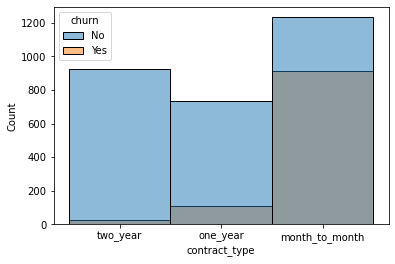

In [22]:
# Visualizing the three variables having the most statistically signficant relationships with churn
sns.histplot(data = explore_cat, x = 'contract_type', hue = 'churn')
plt.plot()


[]

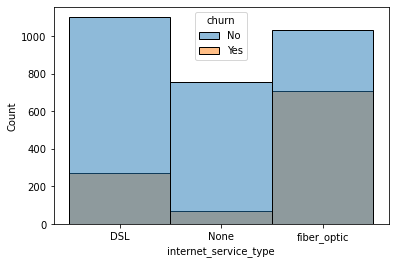

In [23]:
sns.histplot(data = explore_cat, x = 'internet_service_type', hue = 'churn')
plt.plot()

[]

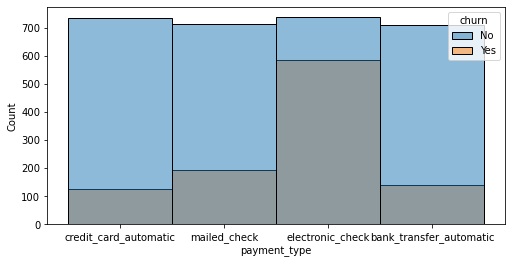

In [24]:
plt.figure(figsize=(8.2,4))
sns.histplot(data = explore_cat, x = 'payment_type', hue = 'churn')
plt.plot()

<img src="img/dashboard_1.png" width=800 height=600 />

- From the graphs above it's clear that the vast majority of customers who churn are month-to-month customers.
    - We also see large churn in Fiber Optic internet customers and customers who pay by electronic check.

**Results from Chi Squared test of categorical variables**

- Both gender and multiple_lines showed NO statistically significant relationship with churn.  These variables can be discarded and not used as features in my models.
- All other variables had statistical signficance showing a relationship between them and churn.  They include:
    - partner
    - dependents
    - online_security
    - online_backup
    - device_protection
    - tech_support
    - streaming_tv
    - streaming_movies
    - paperless_billing
    - contract_type
    - payment_type
    - internet_service_type
    - senior_citizen
    
- I will use all categorical variables from the previous list as features for initial modeling.
    - contract_type, internet_service_type, and payment_type are *strongly* related from persepctive of statistical likelihood.

### Explore Takeaways

- I determined the following categorical variables should be dropped before modeling as they have no signficant relationship to churn:
    - gender
    - multiple_lines
- Of the 3 continous variables total_charges is most likely less powerful a predictor since it correlates highly with tenure. As such it may be necessary to drop it after initial models to find a better performing one.
    

# Modeling
I will be creating initial models with basic hyperparameters for the following types:
- Decision Tree
- Random Forest
- K-nearest neighbors
- Logistic Regression

Additionally I will try two other models:
- Support Vector Machine (SVM)
- Naive Bayes

I will also need to do final processing of the dataframe to make it usable for the models based on the features I want to include.

In [25]:
# I need to do some final clean up post exploration to set up the data for modeling.  This will involve removing all 
# non-encoded columns and dropping columns I determinded during exploration to not be useful features.

train, validate, test = model.pre_model(train, validate, test, drop_columns_list= ['gender_Male', 'multiple_lines_Yes'])

Data is now completely ready to do modeling.

### Setting a Baseline

I now need to define my baseline accuracy to see what the models need to beat.

In [26]:
# The highest value is showing 0 which corresponds to no churn.
train.churn_Yes.value_counts()

0    2891
1    1046
Name: churn_Yes, dtype: int64

In [27]:
1 - train.churn_Yes.mean()

0.7343154686309372

My baseline is 73.4%.  This means that if I were to guess churn_Yes = 0 (no churn) for every customer, I would be correct 73.4% of the time. My final model needs to beat this.

### Defining x and y for train, validate, and test subsets

In [28]:
# Define X and y train
X_train = train.drop(columns=['churn_Yes', 'customer_id'])
y_train = train.churn_Yes

# Define X and y validate
X_validate = validate.drop(columns=['churn_Yes', 'customer_id'])
y_validate = validate.churn_Yes

# Define X and y test
X_test = test.drop(columns=['churn_Yes', 'customer_id'])
y_test = test.churn_Yes

### Decision Tree

I will start with a single model using standard hyperparameters.

In [29]:
# Create the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

# Fit the model to the train dataset
clf.fit(X_train, y_train)

# Score the model on the train dataset

print(f'Accuracy of Decision Tree classifier on training subset: {round(clf.score(X_train, y_train),4)*100}%')

Accuracy of Decision Tree classifier on training subset: 78.13%


After running a function which iterate through max_depth I found a max_depth of 6 to produce the best results of 80.4% on the train and 80.3% on the validate set.  I may be able to get it higher but this is a good starting number.

### Random Forest

I will start with a single model using standard hyperparameters.

In [31]:
# Using standard hyperparameters to get an idea of the accuracy of random forest.  Will iterate more later.
rf = RandomForestClassifier(max_depth=3, random_state=123, min_samples_leaf = 1)
rf.fit(X_train, y_train)

# Scoring the model on the train dataset
print(f'Accuracy of Random Forest classifier on training set: {round(rf.score(X_train, y_train),4)*100}%')

Accuracy of Random Forest classifier on training set: 78.0%


Another not great initial result.  So I will iterate through some common hyperparamters to see how this affects the results.

Using the two hyperparameter max_depth and min_samples_leaf, after running an interation function I've found the best performing model to be max_depth of 9 min_samples_leaf of 12 resulting in Validate accuracy of a 82.9% and Train accuracy of 81.3%.

### K-nearest neighbors

I will start with a single model using standard hyperparameters.

In [33]:
# Using standard hyperparameters to get an idea of the accuracy of KNN model.  Will iterate more later.
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
# Scoring the model on the train dataset
print(f'Accuracy of KNN classifier on training set: {round(knn.score(X_train, y_train),4)*100}%')

Accuracy of KNN classifier on training set: 81.97%


This is the best initial result yet, so I will iterate through n_neighbors to give me an idea of how this model might perform with tweaked hyperparamters.

My initial excitement about this model faded upon seeing the validation accuracy which is under 80% across all iterations of validate results.

### Logistic Regression

I will start with a single model using standard hyperparameters.

In [35]:
# Using standard hyperparameters to get an idea of the accuracy of logistic regression.
logit = LogisticRegression(random_state=123,max_iter=200)
logit.fit(X_train, y_train)
# Scoring the model on the train dataset
print(f'Accuracy of Logistic Regression classifier on training set: {round(logit.score(X_train, y_train),4)*100}%')
print(f'Accuracy of Logistic Regression classifier on validate set: {round(logit.score(X_validate, y_validate),4)*100}%')

Accuracy of Logistic Regression classifier on training set: 79.91%
Accuracy of Logistic Regression classifier on validate set: 81.17%


Overall results seem to be about normal, but on the low end running about 80% accuracy on train and 80.6% accuracy on validate.

## Additional models tested

### Naïve Bayes

In [36]:
# Creating and training the Gaussian Naive Bayes model.
gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)

# Creating and training the Multinomial Naive Bayes model.
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

# Scoring the Gaussian model with standard hyperparameters on the train dataset
print(f'Accuracy of Guassian Naive Bayes classifier on training set: {gauss_nb.score(X_train, y_train)}')
print(f'Accuracy of Guassian Naive Bayes classifier on validate set: {gauss_nb.score(X_validate, y_validate)}\n')

# Scoring the Multinomial model with standard hyperparameters on the train dataset
print(f'Accuracy of Multinomial Naive Bayes classifier on training set: {multi_nb.score(X_train, y_train)}')
print(f'Accuracy of Multinomial Naive Bayes classifier on validate set: {multi_nb.score(X_validate, y_validate)}')

Accuracy of Guassian Naive Bayes classifier on training set: 0.7401574803149606
Accuracy of Guassian Naive Bayes classifier on validate set: 0.7562189054726368
Accuracy of Multinomial Naive Bayes classifier on training set: 0.6616713233426467
Accuracy of Multinomial Naive Bayes classifier on validate set: 0.6624022743425728


Both versions of Naive Bayes perform very poorly, as such I won't be pursuing them further.

### Support Vector Machines (SVM)

In [37]:
# Creating and training the linear SVM model.
linear_svm = SVC(kernel = 'linear')
linear_svm.fit(X_train, y_train)

# Creating and training the rbf SVM model.
rbf_svm = SVC(kernel = 'rbf')
rbf_svm.fit(X_train, y_train)

# Scoring the linear SVM model with standard hyperparameters on the train dataset
print(f'Accuracy of linear SVM classifier on training set: {linear_svm.score(X_train, y_train)}')
print(f'Accuracy of linear SVM classifier on validate set: {linear_svm.score(X_validate, y_validate)}\n')

# Scoring the rbf SVM model with standard hyperparameters on the train dataset
print(f'Accuracy of rbf SVM classifier on training set: {rbf_svm.score(X_train, y_train)}')
print(f'Accuracy of rbf SVM classifier on validate set: {rbf_svm.score(X_validate, y_validate)}')

Accuracy of linear SVM classifier on training set: 0.7912115824231648
Accuracy of linear SVM classifier on validate set: 0.8009950248756219
Accuracy of rbf SVM classifier on training set: 0.7343154686309372
Accuracy of rbf SVM classifier on validate set: 0.7341862117981521


Results for the linear SVM model were slightly worse than other models and results for the rbf SVM model were essentially baseline.
This was a good exercise but I won't continue to follow SVM models here especially since SVM models take a VERY long time to run with this data..

**Conclusion of additional models:** Neither of the additional two models produced better results than the initial four, so I will not pursue them further.

## Models takeaway

- The best performing model thus far was the Random Forest model with the best performing model to be max_depth of 9 min_samples_leaf of 12 resulting in Validate accuracy of a 82.9% and Train accuracy of 81.3%.
- The Random Forest model improves upon the baseline accuracy of 73.4%
- I will thus choose the Random Forest model to do further hyperparameter tuning and feature engineering.

### Hyperparameter Tuning and Feature Engineering for Random Forest Model

I will write a function that iterates through multiple hyperparameters to determine the best performing version of this model.

In [38]:
# rf_super_results_dict = model.rf_super(X_train, y_train, X_validate, y_validate)

# This function took about 2 hours to run through.  So for fear of losing this information and having to rerun it again
# I'm going to export it to csv to have as a reference when needed.

# rf_super_results = pd.DataFrame(rf_super_results_dict)
# rf_super_results.to_csv('rf_super_results.csv', index=False)

# Loading the csv to display here
rf_super_results = pd.read_csv('rf_super_results.csv')

In [39]:
rf_super_results.sort_values(['Validate_accuracy', 'Train_Validate_diff'], ascending = [False, True]).head(15)

,max_depth,min_samples_leaf,min_samples_split,n_estimators,criterion,Train_accuracy,Validate_accuracy,Train_Validate_diff
2376,8,1,6,100,gini,0.830328,0.830846,-0.000518
2040,7,1,6,100,gini,0.816104,0.830135,-0.014031
2052,7,1,8,100,gini,0.816358,0.830135,-0.013777
2439,8,2,8,500,entropy,0.821184,0.830135,-0.008951
2451,8,3,2,500,entropy,0.823470,0.830135,-0.006665
2457,8,3,3,500,entropy,0.823470,0.830135,-0.006665
2463,8,3,4,500,entropy,0.823470,0.830135,-0.006665
2469,8,3,5,500,entropy,0.823470,0.830135,-0.006665
2475,8,3,6,500,entropy,0.823470,0.830135,-0.006665
2384,8,1,7,500,gini,0.828296,0.830135,-0.001839


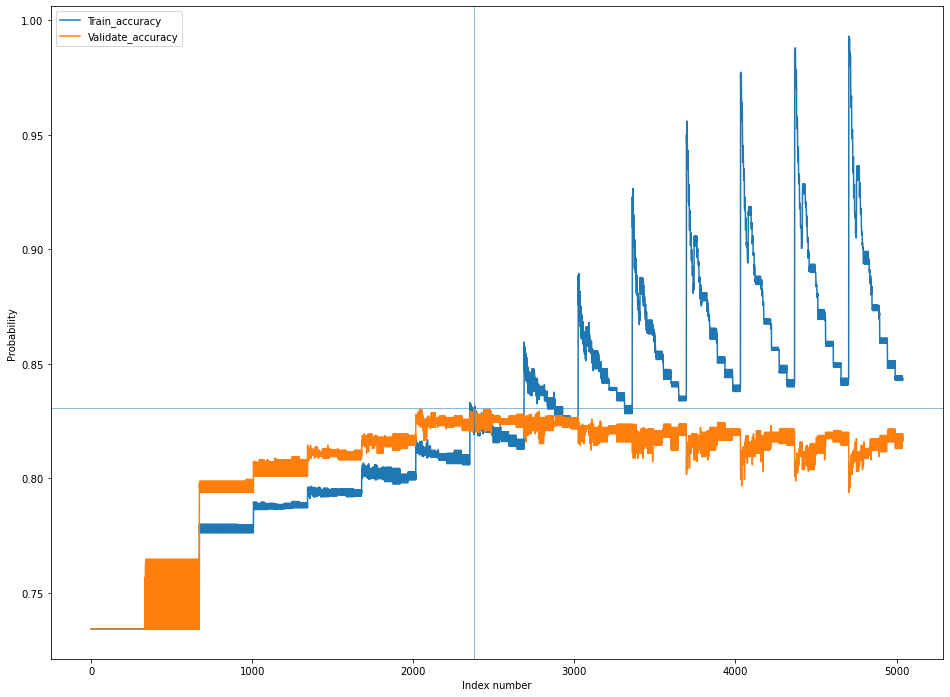

In [40]:
# Visualizing the best performing model #2376
rf_super_results[['Train_accuracy', 'Validate_accuracy']].plot(figsize = (16,12))
plt.xlabel('Index number')
plt.ylabel('Probability')
plt.axvline(2376, lw =.5, label="Best performer")
plt.axhline(0.830846, lw =.5, label = "Highest accuracy")
plt.show()

With the hyperparameter tuning I was able to get my model up a train accuracy of 83.0% and validate accuracy of 83.1%. This is better performing than the previous model and tighter results across train and validate subsets. 

### Testing the final model

In [41]:
# Setting up the final model
final_model = RandomForestClassifier(max_depth=8, min_samples_split= 6, random_state=123, min_samples_leaf = 1, n_estimators = 100,criterion = 'gini')
final_model.fit(X_train, y_train)
print(f'Accuracy of Random Forest classifier on training set: {round(final_model.score(X_train, y_train),4)*100}%')
print(f'Accuracy of Random Forest classifier on validate set: {round(final_model.score(X_validate, y_validate),4)*100}%')


Accuracy of Random Forest classifier on training set: 83.03%
Accuracy of Random Forest classifier on validate set: 83.08%


In [42]:
actual_test = y_test
predicted_test = final_model.predict(X_test)
pd.DataFrame(classification_report(actual_test, predicted_test, output_dict=True)).T

,precision,recall,f1-score,support
0,0.833819,0.923325,0.876293,1239.000000
1,0.699367,0.492205,0.577778,449.000000
accuracy,0.808649,0.808649,0.808649,0.808649
macro avg,0.766593,0.707765,0.727035,1688.000000
weighted avg,0.798056,0.808649,0.796889,1688.000000


The final model when used on the test subset resulted in 80.9%.

## Creating Predictions CSV

- Here I create a .csv file 3 columns: customer_id, probability of churn, and prediction of churn. (1=churn, 0=not_churn).

In [43]:
proba_test = final_model.predict_proba(X_test)
proba_df = pd.DataFrame(proba_test, columns=final_model.classes_.tolist())
proba_df.head()

,0,1
0,0.870319,0.129681
1,0.974440,0.025560
2,0.926233,0.073767
3,0.554136,0.445864
4,0.901361,0.098639


In [44]:
reset_test = test.reset_index()
reset_test.head()

,index,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic,payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic
0,4959,6981-TDRFT,0,44,54.30,2317.10,1,1,0,0,...,1,1,0,1,0,0,1,0,0,0
1,3623,5135-RDDQL,0,63,50.65,3221.25,1,1,1,0,...,0,1,0,0,1,0,0,0,0,0
2,6520,9251-WNSOD,0,67,75.10,5064.45,1,0,1,1,...,1,0,0,1,0,0,0,1,0,0
3,2470,3536-IQCTX,1,32,85.30,2661.10,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
4,1878,2724-FJDYW,0,39,54.85,2191.70,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [45]:
test_proba_df = pd.concat([reset_test, proba_df], axis=1)
test_proba_df['predicted'] = predicted_test
test_proba_df.head()

,index,customer_id,senior_citizen,tenure,monthly_charges,total_charges,partner_Yes,dependents_Yes,online_security_Yes,online_backup_Yes,...,contract_type_one_year,contract_type_two_year,payment_type_credit_card_automatic,payment_type_electronic_check,payment_type_mailed_check,internet_service_type_None,internet_service_type_fiber_optic,0,1,predicted
0,4959,6981-TDRFT,0,44,54.30,2317.10,1,1,0,0,...,1,0,0,1,0,0,0,0.870319,0.129681,0
1,3623,5135-RDDQL,0,63,50.65,3221.25,1,1,1,0,...,0,1,0,0,0,0,0,0.974440,0.025560,0
2,6520,9251-WNSOD,0,67,75.10,5064.45,1,0,1,1,...,1,0,0,0,1,0,0,0.926233,0.073767,0
3,2470,3536-IQCTX,1,32,85.30,2661.10,1,0,0,0,...,0,0,0,1,0,0,1,0.554136,0.445864,0
4,1878,2724-FJDYW,0,39,54.85,2191.70,0,1,0,0,...,1,0,0,0,0,0,0,0.901361,0.098639,0


In [46]:
csv_df = test_proba_df[['customer_id', 1, 'predicted']]
csv_df.columns = ['customer_id', 'probability_of_churn', 'prediction_of_churn']
csv_df.head()

,customer_id,probability_of_churn,prediction_of_churn
0,6981-TDRFT,0.129681,0
1,5135-RDDQL,0.025560,0
2,9251-WNSOD,0.073767,0
3,3536-IQCTX,0.445864,0
4,2724-FJDYW,0.098639,0


In [47]:
# Write DataFrame to a csv file for deliverable.

csv_df.to_csv('predictions.csv')

# Conclusions, Recommendations, Next Steps


- My final model had an accuracy rate 80.9% when predicting for churn on a subset of customers. This is better than the baseline of 73.4%

- We can see from the data that following categories overwhelmingly represent where customers are churning from:
    - **Month-to-Month** contracts
    - Electronic check payment
    - Fiber optic internet customers
- Further the tenure graph below shows that 1/3 of customers who have churned did so before the 4th month.

<img src="img/ten_v_churn.png" />

- Work on retaining customers past that third month. 
    - Do a sort of RCT of incentives randomly offering customers something like the following:
        - Introduce incentives: buy 2 months get 2 free.
        - Offer fiber optic users a reduced payment for the first 6 months.
        - After a year of testing see if they are more likely to stay.
- Customers may be leaving due to frustration with electronic check payments. 
    - Incentivize customers to move to automatic payments: 3 month 20% discount for using an automatic payment method.
    
- For future analytics, it would be nice to know the following information:
    - Date of Churn (around any specific days?)
    - Did the customer just not renew a contract? Or did they actively cancel?
    - Was the customer on a promotion that ended right before they churned?
    - For fiber customers who left, were there any major isp problems (outages, slow speed, high latency?) that contributed to them leaving?
    
- Given further time, I would like to experiment with engineering some more valuable features using the data available to see if I can improve the model.